In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU, ReLU
from tensorflow.keras.layers import Dropout
 
BATCH_SIZE = 32
LEARNING_RATE = 5e-5
ALPHA_WEIGHT = 200
DISCRIMINATOR_FACTOR = 2
 
daccuracies = []
gaccuracies = []

In [2]:
def make_generator_model():
#input layer
   model = tf.keras.Sequential()
   model.add(Dense(4*4*256,use_bias = False, input_shape = (100,)))
   model.add(layers.BatchNormalization())
   model.add(layers.LeakyReLU(0.2))
   model.add(layers.Reshape((4,4,256)))
   assert model.output_shape == (None, 4, 4, 256)
 
#layer 1
 
   model.add(layers.UpSampling2D((2,2)))
   model.add(layers.Conv2DTranspose(128,
                                    (3, 3),
                                    strides=(1, 1),
                                    padding='same',
                                    use_bias = False))
   assert model.output_shape == (None, 8, 8, 128)#maybe wrong
   model.add(layers.LeakyReLU(0.2))
 
#layer 2
 
   model.add(layers.UpSampling2D((2,2)))
   model.add(layers.Conv2DTranspose(64,
                                    (3,3),
                                    strides=(1, 1),
                                    padding='same',
                                    use_bias = False))
   assert model.output_shape == (None,16,16,64)
   model.add(layers.LeakyReLU(0.2))
 
#layer 3 / output layer
   model.add(layers.UpSampling2D((2,2)))
   model.add(layers.Conv2DTranspose(1,
                                    (3,3),
                                    strides=(1, 1),
                                    padding='same',
                                    use_bias = False,
                                    activation='tanh'))   
   assert model.output_shape == (None,32,32 ,1)
   model.add(layers.Cropping2D((2,2)))
   return model
 
generator = make_generator_model()
generator.summary()
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4, beta_1 = 0.5, beta_2 = 0.9)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              409600    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         294912    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [3]:
def make_discriminator_model():
# layer 1
    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape = (28, 28, 1)))
    model.add(layers.ZeroPadding2D((2,2)))
    model.add(layers.Conv2D(64,
                            (5,5),
                            strides=(2,2),
                            padding = 'same',
                            use_bias = True))
    model.add(layers.LeakyReLU(0.2))
 
#layer 2
    model.add(layers.Conv2D(128,
                            (5,5),
                            strides=(2, 2),
                            padding = 'same',
                            use_bias = True))
    model.add(layers.LeakyReLU(0.2))    
 
#layer 3
 
    model.add(layers.Conv2D(256,
                            (5,5),
                            strides=(2, 2),
                            padding = 'same',
                            use_bias = True))
    model.add(layers.LeakyReLU(0.2))    
 
#layer 4
 
    model.add(layers.Conv2D(512,
                            (5,5),
                            strides=(2, 2),
                            padding = 'same',
                            use_bias = True,
                            activation = 'linear'))
    model.add(layers.LeakyReLU(0.2))   
    model.add(layers.Flatten())     
    model.add(Dense(1))
    return model
 
discriminator = make_discriminator_model()
discriminator.summary()
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-4, beta_1 = 0.5, beta_2 = 0.9)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 4, 4, 256)        

In [4]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    total_loss = fake_loss - real_loss
    d = total_loss.numpy()
    daccuracies.append(-d)
    return total_loss

In [5]:
def generator_loss(fake_output):
    x = -tf.reduce_mean(fake_output)
    t = x.numpy()
    for i in range(DISCRIMINATOR_FACTOR):
      gaccuracies.append(-t)
    return x

In [6]:
(train_images,_), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images.astype(np.float32) - 127.5)/127.5
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.batch(BATCH_SIZE)

11493376/11490434 [==============================] - 0s 0us/step


In [7]:
def gradient_penalty(real_images, fake_images, batch_size, alpha_weight):
    # get the interpolated image
    alpha = tf.random.uniform([batch_size,1,1,1],0.0,1.0)
    diff = fake_images - real_images
    interpolated = alpha*real_images + ((1-alpha)*fake_images)
    # 2. Calculate the gradient
    with tf.GradientTape() as tape:
      tape.watch(interpolated)
      pred = discriminator(interpolated)
    grads = tape.gradient(pred, interpolated)[0]
    # 3. Calcuate the norm of the gradients
    norm = ((tf.norm(grads)-0)**2)
    gp1 = tf.reduce_mean(norm)
    gp = alpha_weight*norm
    return gp

In [8]:
def train_step(image,batch_size, discriminator_factor,alpha_weight):
    noise = tf.random.normal([batch_size,100])    
    with tf.GradientTape() as gen_tape:
       generated_images = generator(noise)
       fake_output = discriminator(generated_images)
       gen_loss = generator_loss(fake_output)  
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    for i in range(discriminator_factor):
        with tf.GradientTape() as disc_tape:
            generated_images = generator(noise)
            real_output = discriminator(image)
            fake_output = discriminator(generated_images)
            gp = gradient_penalty(image, generated_images,batch_size, alpha_weight)
            disc_loss = discriminator_loss(real_output, fake_output) 
            d_cost = disc_loss+gp
        gradients_of_discriminator = disc_tape.gradient(d_cost, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))  

In [9]:
def generate_and_save_images(model, test_input):
  predictions = model(test_input, training=False)
  predictions = tf.reshape(predictions, (9,28,28))
  fig = plt.figure(figsize=(9,9))

  for i in range((predictions.shape[0])):
    plt.subplot(3, 3, i+1)
    plt.imshow(predictions[i,:,:] * 255)

  plt.show()

In [10]:
i = 1
seed = tf.random.normal([9, 100])
def train(dataset, epochs):
  for epoch in range(epochs):
    for image_batch in dataset:
      train_step(image_batch,BATCH_SIZE,DISCRIMINATOR_FACTOR, ALPHA_WEIGHT)
      global i
      i = i+1
      if i%33 == 0:
        generate_and_save_images(generator, seed)    
        print("batch no. "+str(i))
      if i >= 100000:
        break

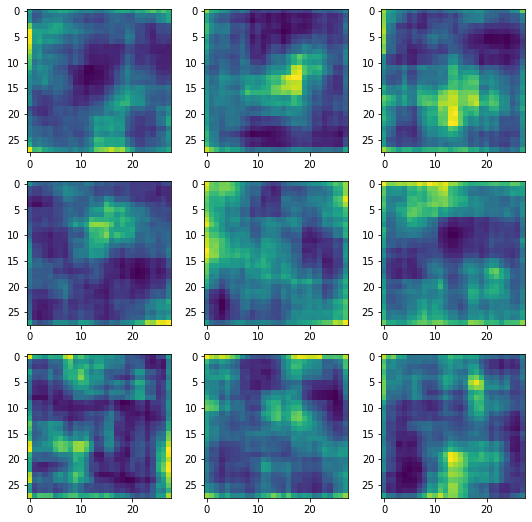

batch no. 33


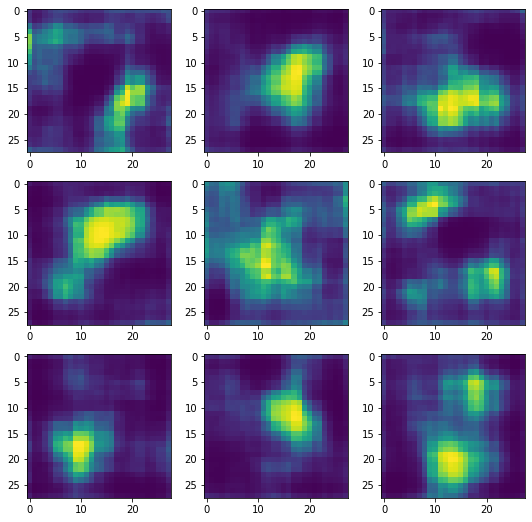

batch no. 66


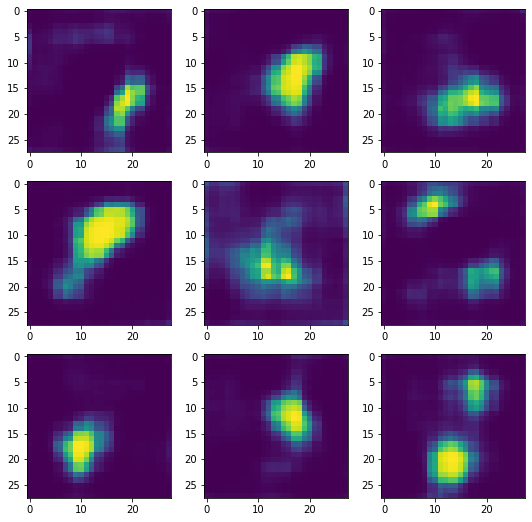

batch no. 99


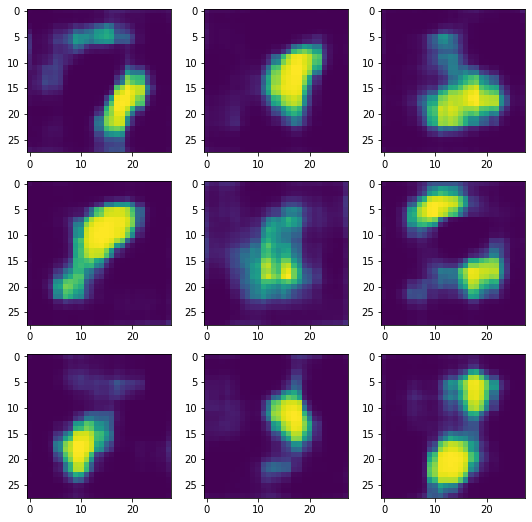

batch no. 132


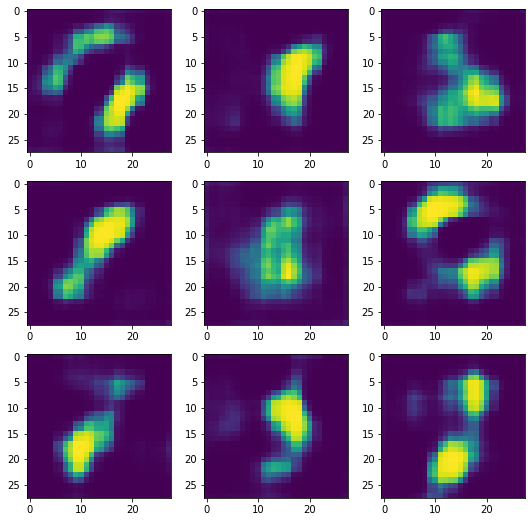

batch no. 165


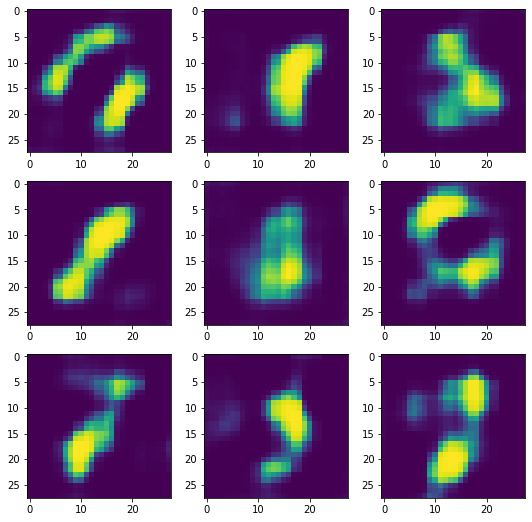

batch no. 198


KeyboardInterrupt: ignored

In [11]:
train(train_dataset,10)

In [ ]:
n = 100 #n must be a square number
test_input = tf.random.normal([n, 100])
predictions = generator(test_input, training=False)   
fig = plt.figure(figsize=(100,100))

for i in range((predictions.shape[0])):
  plt.subplot(np.sqrt(n), np.sqrt(n), i+1)
  plt.imshow(predictions[i,:,:,0] * 127.5 * 127.5) #cmap='Blues'

plt.show() 

In [ ]:
def plotLoss():
    plt.figure(figsize=(10, 8))
    plt.plot(gaccuracies, label='Generative loss')
    plt.plot(daccuracies, label='Discriminative loss')    
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend() 
plotLoss()